In [1]:
%pylab inline
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pretendo hacer posible el uso de diferentes metodos para solucionar
# las ecuaciones diferenciales descritas por dY/dt = der_fun
# Como no todos los metodos requieren la misma informacion sobre los Ys
# y los ts ya existentes (por ejemplo multistep ones like the Adams-Bash one
# requieren de varios momentos anteriores)

def runge_kutta_4th(fun_der, constantes, Ys, dYsdt, timestep, ts):
    # Ys es un diccionario con claves los elementos del array ts
    # dYsdt es un diccionario con claves los elementos del array ts #Asumo, creo que correctamente, que el tiempo me determina todo el estado
    # timestep es el time step que utiliza el metodo    
    
    #TODO validación de argumentos
    
    # Calculo de el valor de Y luego de un timestep
    t_act = ts[-1]
    Y_act = Ys[t_act]
    
    k1 = fun_der(Y_act, t_act, constantes, dYsdt)
    k2 = fun_der(Y_act + timestep * k1 / 2., t_act + timestep / 2., constantes, dYsdt)
    k3 = fun_der(Y_act + timestep * k2 / 2., t_act + timestep / 2., constantes, dYsdt)
    k4 = fun_der(Y_act + timestep * k3, t_act + timestep, constantes, dYsdt)
    
    # Que quien se encargue de guardarlo sea alguien mas, pues, puede que
    # decida simplemente calcular el Y en un tiempo que ya existe, solo para
    # utilizarlo en algo mas, quiza para no obligar que se use solo un metodo
    # para la solucion de los sistemas de masas
    return Y_act + timestep*(k1/6. + k2/3. + k3/3. + k4/6.)

In [3]:
def fun_der_grav(Y, t, constantes, dYsdt):
    
    # Asume Y = array([r1, r2, ..., v1, v2, ...]) con rs y vs array([c1, c2, c3])
    # Asume constantes = [m1, m2, ..., G] con el tipo creo que cualquier sequencia
    
    #TODO Checar longitudes de arrays de masa y Y
    
    # Devolver la derivada si ésta ya ha sido calculada. 
    ##IMPORTANTE:
    ## Asume que no
    ## ocurre recalculo de derivadas, porque asumo que la funcion derivada
    ## solo depende del Y y el t donde se calcula.
    
    if t in dYsdt:
        return dYsdt[t]
    
    masas = array(constantes[: -1])
    G = constantes[-1]
    
    n = len(masas)
    #dYdt = array([]) # Array solucion
    
    # Agregar velocidades a la solucion
    dYdt = Y[n :]
    
    # Agregar aceleraciones
    for i in range(n):
        # Concatena lo que esta a izquierda y derecha para masas y vectores posicion actuales
        masas_act = np.concatenate( (masas[: i], masas[i + 1 :]) , axis = 0) 
        rs_act = np.concatenate( (Y[: i], Y[i + 1 : n]) , axis = 0) - Y[i] # Respecto al actual
        # Suma de aceleraciones debidas a cada masa
        numeradores = G * array([masas_act[i] * rs_act[i] for i in range(n - 1)]) # No igual a multiplicacion de arrays
        denominadores = np.sum(rs_act**2, axis = 1)**(3./2)
        aceleraciones = array([numeradores[i] / denominadores[i] for i in range(n - 1)]) # No igual a división de arrays
        dYdt = np.append(dYdt, [np.sum(aceleraciones, axis = 0)], axis = 0)

    # Agregar resultado al diccionario de derivadas guardadas.
    dYsdt[t] = dYdt #TODO estudiar si el diccionario se pasa completo
    
    return dYdt    

In [54]:
def iguales_n_cifras_sig(x, y, n):
    #if x == 0.:
    #    if y == 0.:
    #        return True
    #    decimales = n - int(floor(np.log10(np.abs(y))) + 1)
    #
    #if y == 0.:
    #    if x == 0.:
    #       return True
    #    
    #print "Comparando", x, y
    #decimales = n - int(floor(np.log10(np.abs(x))) + 1)
    #return np.round(x, decimales) == np.round(y, decimales)
    
    return np.round(x, n) == np.round(y, n)

vec_iguales_cifras = np.vectorize(iguales_n_cifras_sig)

In [431]:
class Sistema_Masas:
    
    def __init__(self, masas, Y_0, fun_derivada, #Cambio a Y_0 para no forzar aun la convencion que usare de posiciones velocidades
                 t_max = 10., 
                 metodo = runge_kutta_4th, timestp = None, cifras_fpos = 9):
        
        #TODO checks
        # check masas positivas, vectores 3D y mismo tamano y misma cantidad que de masas, 
        # t_max positivo, timestp > 0,
        # actual_time > 0 y < a t_max redondeado + timestp, 
        # err_rel_fpos > 0
        
        # Guardar variables necesarias para enteder el sistema y la informacion
        ## guardada
        self.masas = np.array(masas) #any sequence type probably
        self.N = len(masas)
        self.Ys = {}
        self.dYsdt = {}
        #self.ts = array([])
        self.fun_derivada = fun_derivada
        self.metodo = metodo
        
        self.t_max = t_max - t_max % timestp
        self.timestp = timestp
        self.cifras_fpos = cifras_fpos
        
        self.periodica = False
        self.periodo = -100.
        
        # Cuadrar vectores Y en diccionario con keys los tiempos
        # #posiciones_0 = np.array(Y_0[: n])
        # #velocidades_0 = np.array(velocidades_0[n :])
        
        ## Agregar info inicial
        self.ts = np.array([0.])
        self.Ys[self.ts[0]] = Y_0
        
        ## Calculo del sistema en cada tiempo hasta self.t_max
        ####TODO Ys antes
        #print 'Ys antes'
        #print self.Ys
        self.calcular_Ys( )
        ####TODO Ys despues
        #print 'Ys despues'
        #print self.Ys
        #print 'ts despues'
        #print self.ts
        
        # Cambiar estado actual
        self.estado_actual = self.cambiar_estado(self.ts[-1])
    
    def aumentar_t_max(self, t_max):
        
        #TODO Check t_max, if less than current, raise Exc, if periodic, raise Exception (to alert)
        
        # Cambiar el tiempo maximo
        self.t_max = self.redondear_t(t_max)
        
        # Agregar Ys adicionales
        self.calcular_Ys(restart = False)
    
    def cambiar_timestep(self, timestp):
        
        #TODO Check timestp
        
        # Cambiar el time step
        self.timestp = timestp
        
        # Recalcular Ys
        self.calcular_Ys(restart = True)
    
    def cambiar_t_max_y_timestep(self, t_max, timestp):
        
        #TODO Check times
        
        # Cambiar timestp y t_max
        self.timestp = timestp
        self.t_max = self.redondear_t(t_max)
        
        # Recalcular Ys
        self.calcular_Ys(restart = True)
    
    def cambiar_estado(self, t):
        
        # Cambiar tiempo y Y actuales
        self.t_actual = t#self.redondear_tiempo(t)
        self.Y_actual = self.Ys[self.t_actual]
        
    def info_actual(self):
        # Retorna el tiempo y el vector Y del estado actual#Careful with copies
        
        return self.t_actual, self.Y_actual
    
    def energia_cinetica(self):
        # Del estado actual
        # Asume que la segunda parte de ls Ys corresponde a las velocidades
        
        vels_act = self.Y_actual[self.N : 2*self.N]
        return np.sum(array([np.sum(vels_act[i]**2) * self.masas[i] / 2 for i in range(self.N)]))
        
    def energia_potencial(self):
        # Del estado actual
        # Asume que la segunda parte de ls Ys corresponde a las velocidades
        e_potencial = 0
        
        for i in range(self.N - 1):
            # Suma de modo que no se repetan elementos
            m = self.masas[i]
            masas_act = self.masas[i + 1: ]
            r = self.Y_actual[i]
            rs_act = self.Y_actual[i + 1 : self.N] - r # Respecto al actual
            
            # Suma de aceleraciones debidas a cada masa
            numeradores = -G * masas_act 
            denominadores = np.sum(rs_act**2, axis = 1)**(1./2)
            
            e_potencial += np.sum(array([numeradores[i] / denominadores[i] for i in range(self.N - i - 1)])) # No igual a división de arrays
        
        return e_potencial
        
    def energia_total(self):
        # Del estado actual
        # Asume que la segunda parte de ls Ys corresponde a las velocidades
        
        return self.energia_cinetica() + self.energia_potencial()
       
    
    def calcular_Ys(self, restart = False):
        # Calcula los Ys hasta el tiempo máximo
        ## Asume que el tiempo máximo es menor al de un periodo, si es que esto tiene sentido
        
        # Si restart, reasigna los tiempos, los Ys, los dYsdt
        ## y empieza en t = 0
        if restart:
            self.ts = array([0.])
            self.Ys = {Ys[self.ts[0]]} #########3
            self.dYsdt = {}
            self.cambiar_estado(self.ts[0])
        
        #TODO Calcular los Ys
        t = self.ts[-1]
        
        while t < self.t_max:
            ####TODO verificar que entra
            ####print 'Entra al while, tiempo ', t
            timestp = self.time_step_adecuado(t)
            # Calcular siguiente Y
            Y = self.metodo(self.fun_derivada, np.append(self.masas, [G], axis = 0), 
                            self.Ys, self.dYsdt, timestep = self.timestp, ts = self.ts)
            
            # If new Y is good enough to determine periodicity, change period stuff, t_max and break
            if prod(vec_iguales_cifras(Y, self.Ys[self.ts[0]], self.cifras_fpos)):
                ####TODO verificar periodicidad
                ####print 'Entra por creer periodicidad, tiempo ', t + timestp
                self.periodica = True
                self.periodo = t
                self.t_max = t
                break
            
            # Advance a timestep
            t += self.timestp
            t = self.redondear_tiempo(t)
            
            # Store new Y and t
            self.Ys[t] = Y
            self.ts = np.append(self.ts, [t], axis = 0)
    
    def time_step_adecuado(self, t): #TODO improve
        
        # Asume t en ts
        if self.timestp != None:
            return self.timestp
        
        return self.timestp
    
    def redondear_tiempo(self, t): #Mejor llamarla en caso de querer utilizar un metodo que no utilice pasos uniformes
        # Asume que t es positivo
        
        if not self.periodica and t > self.t_max + self.timestp: #TODO tal vez cambiar este check a alguien más
            raise Exception('Tiempo muy largo, aumentar primero tiempo maximo')
        
        if self.periodica:
            t = t % self.periodo
            
        #return t - t % self.timestp
        #print 'Redondeando'
        #print 't', t
        #print 'cociente', t/self.timestp
        #print 'round cociente', round(t/self.timestp)
        #print 't, timestep, round cociente', t, self.timestp, round(t/self.timestp, 0)
        return self.timestp * round(t/self.timestp, 0)
        

In [243]:
 def animacion(titulo, rapidez = 1., segundos = None, fraccion = 1., largo_cola = .1, framesps = 10): # TODO
        
        # Asume formato [r1, r2, r3, ..., we1, we...]
        # Rapidez y segundos se excluyen entre si, con prioridad rapidez
        
        fig = plt.figure(titulo)
        ax = fig.add_subplot(111)
        ax.grid('on')
        ax.set_title('Coreografia 3 cuerpos')
        
        #ax.plot( )
        
        if segundos == None:
            # La animación es entonces de la fracción del t_max, a la rapidez indicada, con tantos framesps
            segundos = rapidez * t_max * fraccion
            
            def animate(i):
                ax.lines = []
                
                Y_act = self.Ys[self.times[i]]
                ax.plot(Y_act[: n, 0], Y_act[: n, 1], 'o')
                #TODO cola   
                return ax.lines
        
        else:
            
        
def animate(self, i):
    pass

IndentationError: expected an indented block (<ipython-input-243-83c6e45b4822>, line 28)

# 3-Coreografía

## a.

In [244]:
a = 0.24250109
b = -0.0607718825
c = 0.93240737
d = 0.86473146

G = 1.

In [245]:
Y_0 = np.array([np.array([a, b, 0.]), np.array([-a, -b, 0.]), np.array([0., 0., 0.]),
                np.array([c, d, 0.]), np.array([c, d, 0.]), np.array([-2.*c, -2*d, 0.])])

masas = array([1., 1., 1.])

In [ ]:
sistema = Sistema_Masas(masas, Y_0, fun_der_grav, timestp = 0.0001, t_max = 0.7908, cifras_fpos = 2)

In [247]:
print sistema.periodica
print sistema.periodo

True
0.7906


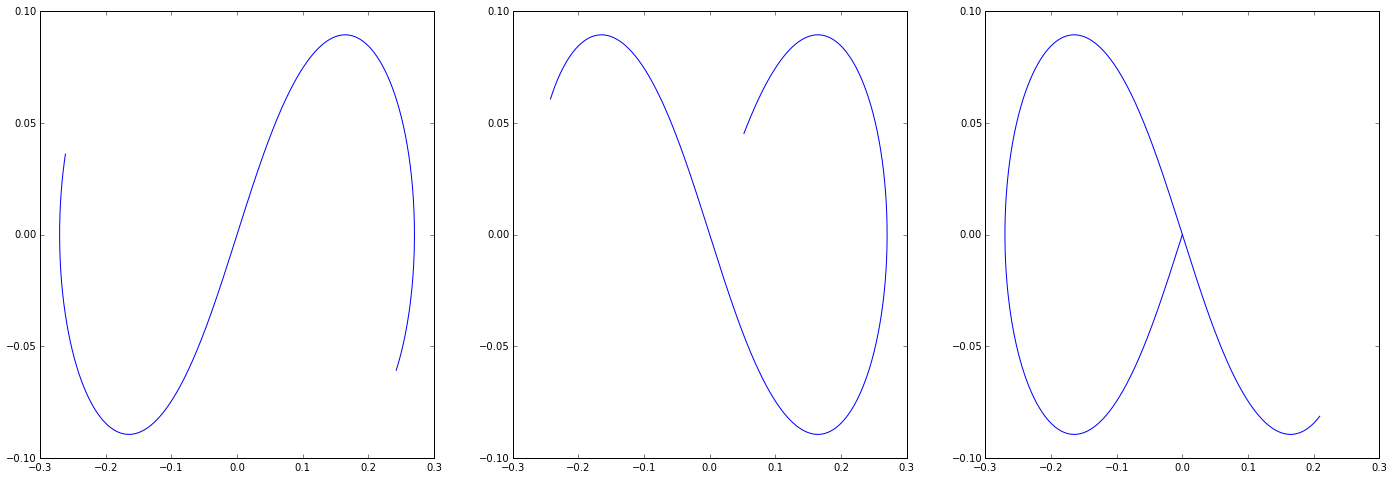

In [248]:
fig_1 = plt.figure('Punto 1', figsize = (24, 8))

ax_11 = fig_1.add_subplot(131)
ts = [t for t in sistema.ts[:5000]]
xs = [sistema.Ys[t][0, 0] for t in ts]
ys = [sistema.Ys[t][0, 1] for t in ts]
ax_11.plot(xs, ys)

ax_12 = fig_1.add_subplot(132)
ts = [t for t in sistema.ts[:5000]]
xs = [sistema.Ys[t][1, 0] for t in ts]
ys = [sistema.Ys[t][1, 1] for t in ts]
ax_12.plot(xs, ys)

ax_13 = fig_1.add_subplot(133)
ts = [t for t in sistema.ts[:5000]]
xs = [sistema.Ys[t][2, 0] for t in ts]
ys = [sistema.Ys[t][2, 1] for t in ts]
ax_13.plot(xs, ys)

# 4-Coreografía 

## 2.1 Calculando a

In [301]:
# La idea es minimizar la distancia entre las posiciones iniciales y finales,
## asumiendo que el periodo es 1. (dicho por profesor).
## Para hacer esto, se puede recursivamente partir el intervalos más pequeños,
## en este caso creo que con steps del tamaño del decimal siguiente a encontrar,
## y elegir aquel donde la distancia y velocidad (normalizando con valores comparables a su magnitud) 
## se minimiza. Así hasta encontrar a con 5 cifras decimales

a_min = 0.70
a_max = 0.78
step = 0.01

dist_norm = .1
vel_norm = 1.
i = 0

while step >= 0.00001:
    errores = array([])
    
    a_act = a_min
    while a_act <= a_max:
        Y_0[4] = array([0., a_act, 0.])
        
        sist = Sistema_Masas(masas, Y_0, fun_der_grav, timestp = 0.001/3**i, t_max = T, cifras_fpos = 4)
        diff_Ys_sq = (sist.Ys[sist.ts[-1]] - sist.Ys[sist.ts[0]])**2
        
        error = (np.sum(diff_Ys_sq[0] + diff_Ys_sq[1] + diff_Ys_sq[2] + diff_Ys_sq[3]))/dist_norm**2 + (np.sum(diff_Ys_sq[4] + diff_Ys_sq[5] + diff_Ys_sq[6] + diff_Ys_sq[7]))/vel_norm**2
        
        errores = np.append(errores, error)
        a_act += step
    
    minimo_indice = np.argmin(errores)
    print minimo_indice
    a_min = a_min + step*minimo_indice
    a_max = a_min + step
    print a_min
    print a_max
    step = step / 10
    i += 1
        

6
0.76
0.77
0
0.76
0.761
2
0.7602
0.7603
0
0.7602
0.76021


# 2.2 Gráfica de energías

In [432]:
a = 0.76020
sistema2 = Sistema_Masas(masas, Y_0, fun_der_grav, timestp = 0.0001, t_max = 0.999666, cifras_fpos = 3)

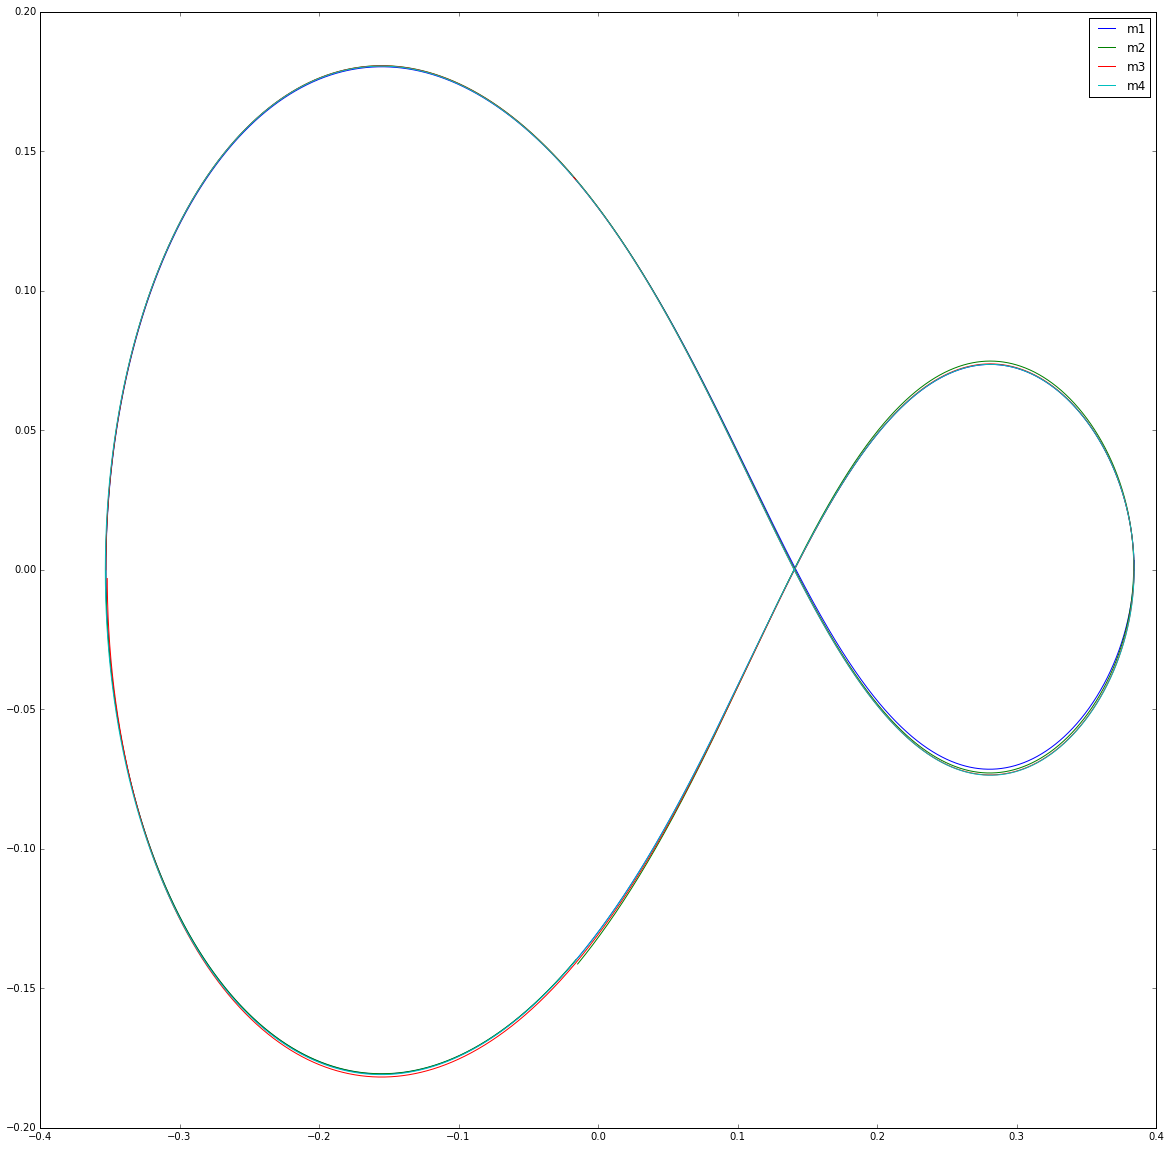

In [433]:
fig_2 = plt.figure('Punto 2', figsize = (20, 20))

#ax_11 = fig_1.add_subplot(131)

ts = [t for t in sistema2.ts[:]]

ax = fig_2.add_subplot(111) 
xs = [sistema2.Ys[t][0, 0] for t in ts]
ys = [sistema2.Ys[t][0, 1] for t in ts]
ax.plot(xs, ys, '-', label = 'm1')

xs = [sistema2.Ys[t][1, 0] for t in ts]
ys = [sistema2.Ys[t][1, 1] for t in ts]
ax.plot(xs, ys, '-' , label = 'm2')

xs = [sistema2.Ys[t][2, 0] for t in ts]
ys = [sistema2.Ys[t][2, 1] for t in ts]
ax.plot(xs, ys, '-', label = 'm3')

xs = [sistema2.Ys[t][3, 0] for t in ts]
ys = [sistema2.Ys[t][3, 1] for t in ts]
ax.plot(xs, ys, '-', label = 'm4')

ax.legend()

In [434]:
numero = 1000

ts_sin_proc = sistema2.ts
i_base = int(len(ts_sin_proc) / numero)

ts = array([ts_sin_proc[i * i_base] for i in range(0, numero)])
#ts = np.append(ts, ts_sin_proc[-1])
e_cineticas = np.zeros(np.size(ts))
e_potenciales = np.zeros(np.size(ts))
e_totales = np.zeros(np.size(ts))

for i in range(numero):
    t = ts[i]
    sistema2.cambiar_estado(t)
    
    e_cineticas[i] = sistema2.energia_cinetica( )
    e_potenciales[i] = sistema2.energia_potencial( )
    e_totales[i] = sistema2.energia_total( )
    

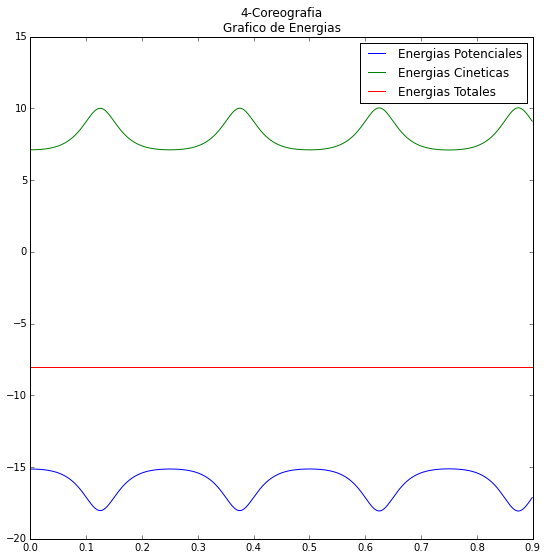

In [439]:
fig_ene = plt.figure('Energias', figsize = (9, 9))
ax_ene = fig_ene.add_subplot(111)
ax_ene.set_title('4-Coreografia\nGrafico de Energias')

ax_ene.plot(ts, e_potenciales, label = 'Energias Potenciales')
ax_ene.plot(ts, e_cineticas, label = 'Energias Cineticas')
ax_ene.plot(ts, e_totales, label = 'Energias Totales')
ax_ene.legend( )

In [67]:
print len(sistema.ts)
print sistema.ts

79074
[  0.00000000e+00   1.00000000e-05   2.00000000e-05 ...,   7.90710000e-01
   7.90720000e-01   7.90730000e-01]


In [68]:
print sistema.Ys[0.]
print sistema.Ys[sistema.ts[-1]]

[[ 0.24250109 -0.06077188  0.        ]
 [-0.24250109  0.06077188  0.        ]
 [ 0.          0.          0.        ]
 [ 0.93240737  0.86473146  0.        ]
 [ 0.93240737  0.86473146  0.        ]
 [-1.86481474 -1.72946292  0.        ]]
[[  2.42492461e-01  -6.07798869e-02   0.00000000e+00]
 [ -2.42509721e-01   6.07638807e-02   0.00000000e+00]
 [  1.72595678e-05   1.60061926e-05   0.00000000e+00]
 [  9.32586937e-01   8.64686447e-01   0.00000000e+00]
 [  9.32227803e-01   8.64776440e-01   0.00000000e+00]
 [ -1.86481474e+00  -1.72946289e+00   0.00000000e+00]]


In [61]:
np.append(array([1.,1.,1.,]), [1.], axis = 0)

array([ 1.,  1.,  1.,  1.])

In [101]:
ms = array([1., 2., 1.,])[:-1]
rs = Y_0[: 3][:-1]
print ms
print
print rs
print
print array([ms[i] * rs[i] for i in range(2)])
print
print np.sqrt(np.sum(rs**2, axis = 1))**3
print
print array([array([ms[i] * rs[i] for i in range(2)])[i] / (np.sqrt(np.sum(rs**2, axis = 1))**3)[i] for i in range(2)])

[ 1.  2.]

[[ 0.24250109 -0.06077188  0.        ]
 [-0.24250109  0.06077188  0.        ]]

[[ 0.24250109 -0.06077188  0.        ]
 [-0.48500218  0.12154376  0.        ]]

[ 0.015625  0.015625]

[[-31.04013926   7.77880089   0.        ]
 [-31.04013926   7.77880089   0.        ]]


In [3]:
ara = array([[1., 2., 3.], [4., 5., 6.]])

print np.sum(ara, axis = 0)
print np.sum(ara, axis = 1)
print np.sum(ara**2, axis = 1)

[ 5.  7.  9.]
[  6.  15.]
[ 14.  77.]


In [141]:
y1 = array([1., 2.,3.,4.,5.,6.])
y2 = array([1.1, 2.1, 3.1, 4.1, 5.1, 6.1])

print np.vectorize(iguales_n_cifras_sig)(y1, y2, 2)
print np.vectorize(iguales_n_cifras_sig)(y1, y2, 1)

y2 = array([1.01, 2.01, 3.01, 4.01, 5.01, 6.01])

print np.vectorize(iguales_n_cifras_sig)(y1, y2, 2)
print vec_iguales_cifras(y1, y2, 2)
print prod(np.vectorize(iguales_n_cifras_sig)(y1, y2, 1))

[False False False False False False]
[ True  True  True  True  True  True]
[ True  True  True  True  True  True]
[ True  True  True  True  True  True]
1


In [18]:
Y = array([0.1, 0.1, 0.1])
Z = array([0.11, 0.11, 0.11])
Z1 = array
x = 0.01
y = 0.011
n = 2
print x / 10**(floor(np.log10(x)) + 1)
print y / 10**(floor(np.log10(y)) + 1)
print np.round(x / 10**(floor(np.log10(y)) + 1) - x / 10**(floor(np.log10(y)) + 1))

print np.round(x, n - int(floor(np.log10(x)) + 1))
print np.round(y, n - int(floor(np.log10(y)) + 1))

print np.round(x, 1 - int(floor(np.log10(x)) + 1))
print np.round(y, 1 - int(floor(np.log10(y)) + 1))

0.1
0.11
0.0
0.01
0.011
0.01
0.01


In [53]:
f = iguales_n_cifras_sig
print f(1.123, 1.124, 2)
print f(1.123, 1.124, 3)
print f(1.123, 1.124, 4)
print f(-1.123, 1.124, 2)
print f(-1.123, 1.124, 3)
print f(-1.123, 1.124, 4)
print f(-1.123, -1.124, 2)
print f(-1.123, -1.124, 3)
print f(-1.123, -1.124, 4)
print f(0., 0.0001, 1)

Comparando 1.123 1.124
True
Comparando 1.123 1.124
True
Comparando 1.123 1.124
False
Comparando -1.123 1.124
False
Comparando -1.123 1.124
False
Comparando -1.123 1.124
False
Comparando -1.123 -1.124
True
Comparando -1.123 -1.124
True
Comparando -1.123 -1.124
False
False


In [74]:
floor(np.log10(0.0123))

-2.0

In [287]:
np.argmin(array([1., 2., 0., 1., 0.]))

2